<a href="https://colab.research.google.com/github/mong-pnh/DS24-CoderSchool2020/blob/master/Copy_of_Weekly_Project_BBC_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [ ]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [ ]:
bbc.sample(5)

,category,text
1319,sport,hereford 1-1 doncaster hereford win 3-1 on pen...
1402,sport,davenport dismantles young rival top seed lind...
1978,business,venezuela reviews foreign deals venezuela is t...
1757,tech,nuclear body seeks new tech the computer syste...
1011,business,making your office work for you our mission to...


In [ ]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
# Your code here
bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
# Map Textual labels to numeric using Label Encode
from sklearn.preprocessing import LabelEncoder
bbc['category_id'] = LabelEncoder().fit_transform(bbc['category'])

In [ ]:
bbc.head()

,category,text,label
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(bbc['text']).toarray()
labels = bbc['category_id']

In [ ]:
category_to_id = {'business':0, 'tech':4, 'politics':2, 'sport':3, 'entertainment':1}
id_to_category = {0: 'business', 4: 'tech', 2: 'politics', 3: 'sport', 1: 'entertainment'}

In [ ]:
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [ ]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

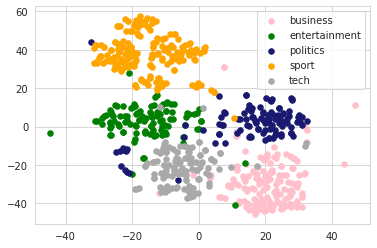

In [ ]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.legend()

In [ ]:
# Comparing different model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score


models = [
    
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3)
]

In [ ]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

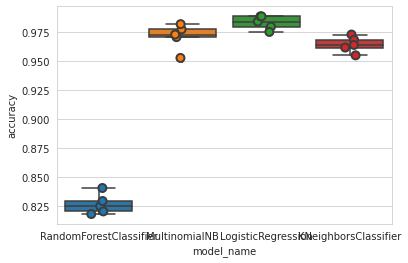

In [ ]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.964494
LogisticRegression        0.983371
MultinomialNB             0.971236
RandomForestClassifier    0.826517
Name: accuracy, dtype: float64

In [ ]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.824719
1,RandomForestClassifier,1,0.817978
2,RandomForestClassifier,2,0.840449
3,RandomForestClassifier,3,0.820225
4,RandomForestClassifier,4,0.829213
5,MultinomialNB,0,0.970787
6,MultinomialNB,1,0.977528
7,MultinomialNB,2,0.982022
8,MultinomialNB,3,0.952809
9,MultinomialNB,4,0.973034


In [ ]:
# Divide data into two sets
from sklearn.model_selection import train_test_split
# Using Random Forest
model = RandomForestClassifier()

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, bbc.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [ ]:
category_id_df = bbc[['category', 'label']].drop_duplicates().sort_values('label')

Text(0.5, 15.0, 'Predicted')

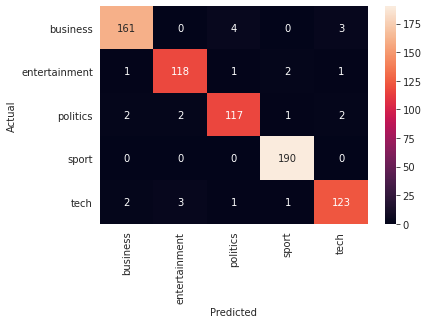

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['category'].values, yticklabels=category_id_df['category'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
from IPython.display import display

for predicted in category_id_df['label']:
   for actual in category_id_df['label']:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(bbc.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['text'])
      print('')

'politics' predicted as 'business' : 2 examples.


1717    borders rail link campaign rally campaigners a...
359     baa support ahead of court battle uk airport o...
Name: text, dtype: object


'tech' predicted as 'business' : 2 examples.


1741    us state acts to stop  spammers  us state texa...
19      games maker fights for survival one of britain...
Name: text, dtype: object


'politics' predicted as 'entertainment' : 2 examples.


384     drive to  save  festive holidays efforts are b...
1051    uk helps raped rwandan women britain is to giv...
Name: text, dtype: object


'tech' predicted as 'entertainment' : 3 examples.


1382    more movies head to sony s psp movies open wat...
646     gritty return for prince of persia still baski...
1512    half-life 2 sweeps bafta awards pc first perso...
Name: text, dtype: object


'business' predicted as 'politics' : 4 examples.


1380    world leaders gather to face uncertainty more ...
2002    salary scandal in cameroon cameroon says wides...
2201    ban on forced retirement under 65 employers wi...
1809    golden rule  intact  says ex-aide chancellor g...
Name: text, dtype: object


'entertainment' predicted as 'sport' : 2 examples.


1127    my memories of marley...  to mark the 60th ann...
997     rap boss arrested over drug find rap mogul mar...
Name: text, dtype: object


'business' predicted as 'tech' : 3 examples.


1360    call centre users  lose patience  customers tr...
1748    id theft surge hits us consumers almost a quar...
159     orange colour clash set for court a row over t...
Name: text, dtype: object


'politics' predicted as 'tech' : 2 examples.


2100    us casino  tricks  face ban in uk controversia...
2107    game warnings  must be clearer  violent video ...
Name: text, dtype: object

In [ ]:
model2 = RandomForestClassifier()
model2.fit(features, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Using Keras
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models

In [ ]:
train_size = int(len(bbc) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(bbc) - train_size))

Train size: 1780
Test size: 445


In [ ]:
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [ ]:
train_cat, test_cat = train_test_split(bbc['category'], train_size)
train_text, test_text = train_test_split(bbc['text'], train_size)

In [ ]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

In [ ]:
num_classes = int(np.max(y_train) + 1)
y_train = keras.utils.to_categorical(y_train, num_classes, dtype='float64')
y_test = keras.utils.to_categorical(y_test, num_classes, dtype='float64')

In [ ]:
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [ ]:
# Build the model
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
# model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/2
51/51 [==============================] - 0s 8ms/step - loss: 0.4377 - accuracy: 0.8814 - val_loss: 0.1453 - val_accuracy: 0.9494
Epoch 2/2
51/51 [==============================] - 0s 5ms/step - loss: 0.0481 - accuracy: 0.9931 - val_loss: 0.1193 - val_accuracy: 0.9663


In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 [==============================] - 0s 3ms/step - loss: 0.1430 - accuracy: 0.9528
Test loss: 0.1429637223482132
Test accuracy: 0.9528089761734009


In [ ]:
def run_experiment(batch_size, epochs, drop_ratio):
  print('batch size: {}, epochs: {}, drop_ratio: {}'.format(
      batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)
  score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [ ]:
batch_size = 16
epochs = 4
drop_ratio = 0.4
run_experiment(batch_size, epochs, drop_ratio)

batch size: 16, epochs: 4, drop_ratio: 0.4
	Test loss: 0.13697578012943268
	Test accuracy: 0.9573033452033997


In [ ]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual label:' + test_cat.iloc[i])
    print("Predicted label: " + predicted_label + "\n")  

hobbit picture  four years away  lord of the rings ...
Actual label:entertainment
Predicted label: entertainment

game firm holds  cast  auditions video game firm b ...
Actual label:tech
Predicted label: tech

clarke plans migrant point scheme anyone planning  ...
Actual label:politics
Predicted label: politics

radcliffe will compete in london paula radcliffe w ...
Actual label:sport
Predicted label: sport

serena becomes world number two serena williams ha ...
Actual label:sport
Predicted label: sport

ultimate game  award for doom 3 sci-fi shooter doo ...
Actual label:tech
Predicted label: tech

algeria hit by further gas riots algeria suffered  ...
Actual label:business
Predicted label: business

fast lifts rise into record books two high-speed l ...
Actual label:tech
Predicted label: tech

muslim group attacks tv drama 24 a british muslim  ...
Actual label:entertainment
Predicted label: entertainment

us tv special for tsunami relief a us television n ...
Actual label:entertainmen